In [ ]:
pip install -r ./requirements.txt

# E-scooter analysis in Malmö

A lot of the code was copy/pasted from a text file, as it was written in another interactive Python environment. It mostly does run without problems, but there are quite a few warnings and some cells that seem to be missing certain child dependencies.

In [2]:
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from geopy.distance import geodesic as GD
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, LineString
from shapely.geometry.multipolygon import MultiPolygon
import folium
import contextily as cx
from OSMPythonTools.overpass import Overpass
import pickle
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

### TIER Zone data

In [6]:
def get_zones(filename): 
    f = open(filename)
    res = json.load(f)
    atts = [x['attributes'] for x in res['data']]
    locs = pd.DataFrame(atts)

    locs['geometry'] = locs.apply(lambda x: Polygon([(c['lng'], c['lat']) for c in x.polygon]), 1)
    zones = gpd.GeoDataFrame(locs, geometry="geometry", crs='epsg:4326')
    return zones

constrained = get_zones('./data/constrained_malmo_tier.json')
singles = constrained[constrained.zoneConstraints.map(len) == 1]

noParkingSlow = constrained[constrained.zoneConstraints.map(len) == 2]
slowZone = singles[singles.zoneConstraints.map(lambda x: x[0]) == 'speedReduction']
noParking = singles[singles.zoneConstraints.map(lambda x: x[0]) == 'noParking']
parking = get_zones('./data/parking_malmo_tier.json')
root_zone = get_zones('./data/root_malmo_tier.json')
parking_centroids = gpd.GeoDataFrame(parking, geometry=gpd.points_from_xy(parking.lng, parking.lat), crs='epsg:4326')

### Bike rentals data (MalmöByBike)

In [28]:
# overpass = Overpass()
# result = overpass.query('node["amenity"="bicycle_rental"](area::malmo); out;')
bike_rentals = gpd.read_file('./data/bike_rentals_greater_cph.geojson', crs='epsg:4326')
bike_rentals = bike_rentals[['description','name', 'network','geometry']]
bike_rentals = bike_rentals[bike_rentals.network == 'Malmö by bike']

#### Plot and export SVG shapes

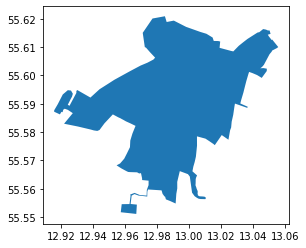

In [7]:
ax = root_zone.plot()
plt.show()

mp = MultiPolygon(list(noParkingSlow.to_crs(epsg=3857).geometry))
# Save shape as SVG
with open('noParkingSlow.svg', 'w') as f:
    f.write(mp._repr_svg_())

#### Malmö SCB (DeSO) boundaries

In [29]:
reso = gpd.read_file('./data/SE_deso_boundaries.gpkg')
malmo = reso[reso.kommunnamn == 'Malmö']
malmo = malmo.set_crs(epsg=3006).to_crs(epsg=4326)

# Plot folium
#m = folium.Map([55.58791, 13.00081], zoom_start=12, tiles='cartodbpositron')
#folium.GeoJson(test['from']).add_to(m)
#m.save("map.html")

# Overlap between TIER operational area and DeSO areas
overlap = gpd.overlay(malmo, root_zone, how='intersection')
tier_deso = malmo[malmo.deso.isin(overlap.deso)]
non_tier_deso = malmo[~malmo.deso.isin(overlap.deso)]

ImportError: Spatial indexes require either `rtree` or `pygeos`. See installation instructions at https://geopandas.org/install.html

#### Population data

In [ ]:
f = open('./data/population_age_deso.json')
population_json = json.load(f)

df_dict = {}
for row in population_json['data']:
    deso_id = row['key'][0]
    category = row['key'][1]
    if deso_id not in df_dict:
        df_dict[deso_id] = {}
    df_dict[deso_id][category] = int(row['values'][0])

population_deso = pd.DataFrame.from_dict(df_dict, orient='index')
population_deso.index.name = 'deso2'
population_deso['deso'] = population_deso.apply(lambda x: x.name, 1)

young_ages = ['-4', '5-9', '10-14', '15-19', '20-24']
population_deso['under_25'] = population_deso[young_ages].sum(axis=1)
population_deso['under_25_norm'] = population_deso['under_25']/population_deso['totalt']

# Population covered by TIER
cov = sum(population_deso.merge(tier_deso, on='deso').totalt)
not_cov = sum(population_deso.merge(non_tier_deso, on='deso').totalt)
malmo_population = cov+not_cov
cov/malmo_population

#### Population data (cars)

In [ ]:
f = open('./data/cars_deso.json')
cars = json.load(f)

cars = pd.DataFrame(cars['data'])
cars['deso'] = cars.apply(lambda x: x['key'][0], 1)
cars['total'] = cars.apply(lambda x: int(x['values'][0]), 1)
cars = cars[['deso', 'total']]

cars_malmo = cars[cars.deso.isin(malmo.deso)]
cars_malmo = gpd.GeoDataFrame(pd.merge(cars_malmo, malmo[['deso', 'geometry']], on='deso'), geometry='geometry')
cars_malmo = gpd.GeoDataFrame(pd.merge(cars_malmo, population_deso[['deso', 'totalt', 'under_25_norm']], on='deso'), geometry='geometry')
cars_malmo['cars_per_100'] = (cars_malmo['total']/cars_malmo['totalt'])*100
cars_malmo.iloc[0]


cars[cars.deso == '0114A0010']

cars_min, cars_max = cars_malmo['cars_per_100'].min(), cars_malmo['cars_per_100'].max()
cars_malmo['total_norm'] = (cars_malmo['cars_per_100']-cars_min)/cars_max

In [ ]:
norm = TwoSlopeNorm(vmin=cars_min, vcenter=27.0, vmax=cars_max)
cmap = 'RdBu'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
root_zone.to_crs(epsg=3857).plot(ax=ax, facecolor='none', edgecolor='teal', linewidth=2, label="Missing values")
cars_malmo.to_crs(epsg=3857).plot(ax=ax, alpha=0.7, linewidth=0.3, edgecolor='black', column='under_25_norm', cmap=cmap, legend=True)
root_zone.to_crs(epsg=3857).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, label="Missing values", alpha=0.7)
cx.add_basemap(ax, zoom=12, source=cx.providers.CartoDB.Positron)
minx, miny, maxx, maxy = root_zone.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()
ax.legend()
plt.show()

### Misc. metadata

In [ ]:
# Convex-hull parking perimiter
# -------------------------------------------------------
cvp = parking_centroids.unary_union.convex_hull
parking_buffer = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[cvp])


# Plotting restricted zones
# -------------------------------------------------------
root_buffer = gpd.GeoDataFrame(root_zone.buffer(-0.0019, resolution=150), geometry=0)
root_edge = root_zone.overlay(root_buffer, how='symmetric_difference')


# Transit hubs
# -------------------------------------------------------
transit_hubs = [(55.6091534, 13.000106), (55.6091966, 13.004069740), (55.60903328, 12.996944352), (55.59201697, 13.00177384), (55.5944530, 13.0004943), (55.563181, 12.9768425), (55.5804429, 13.0292447), (55.589560, 13.031194), (55.6076402, 13.0324545), (55.58877913, 13.00637692), (55.6056939, 13.02362259)]
transit_hubs = [Point(lon, lat) for lat, lon in transit_hubs]
transit_hubs = gpd.GeoDataFrame(transit_hubs, crs='epsg:4326', columns=['geometry'])


#### Plots using basemaps

/usr/local/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


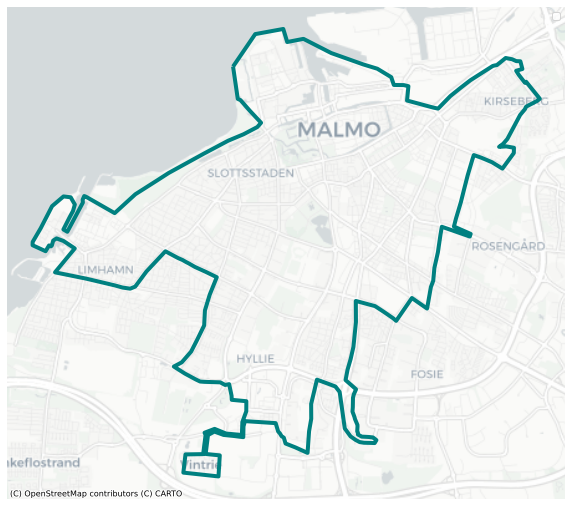

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
tier_deso.to_crs(epsg=3857).plot(ax=ax, alpha=0.15, facecolor='teal', edgecolor='darkslategrey')
non_tier_deso.to_crs(epsg=3857).plot(ax=ax, alpha=0.25, facecolor='maroon', edgecolor='tomato', label="test")
root_zone.to_crs(epsg=3857).plot(ax=ax, facecolor='none', edgecolor='teal', linewidth=4, label="Missing values")
cx.add_basemap(ax, zoom=12, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.legend(['First line', 'Second line'])
plt.show()

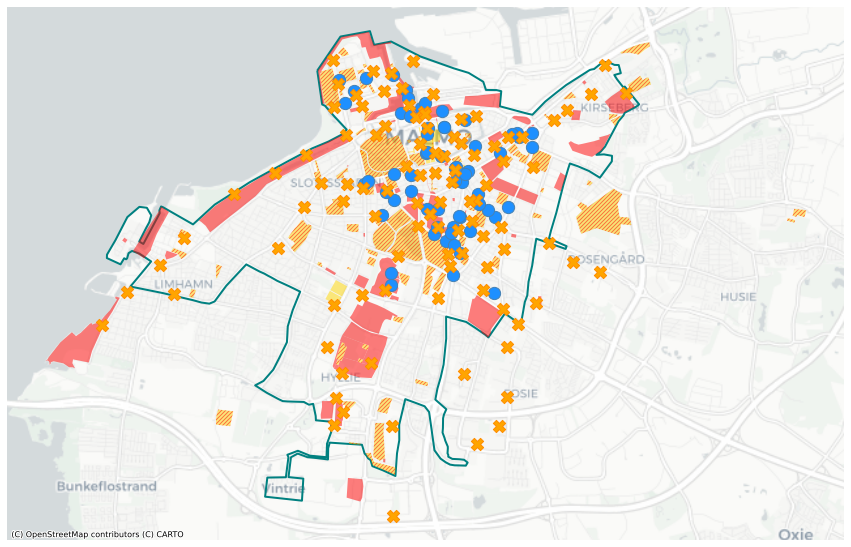

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
root_zone.to_crs(epsg=3857).plot(ax=ax, facecolor='none', edgecolor='teal', linewidth=2, label="Missing values", alpha=0.7)
root_zone.overlay(tier_deso, how='intersection').to_crs(epsg=3857).plot(ax=ax, alpha=alpha, facecolor='none', edgecolor='r', linewidth=1, hatch="///")
root_edge.to_crs(epsg=3857).plot(ax=ax, facecolor='red', alpha=0.5)
transit_hubs.to_crs(epsg=3857).plot(ax=ax, color='orange', edgecolor='darkorange', marker='X', markersize=150)
noParking.to_crs(epsg=3857).plot(ax=ax, alpha=alpha, facecolor='r', edgecolor='tomato', linewidth=0)
slowZone.to_crs(epsg=3857).plot(ax=ax, alpha=alpha, facecolor='gold', edgecolor='gold', linewidth=0)
noParkingSlow.to_crs(epsg=3857).plot(ax=ax, alpha=alpha, facecolor='gold', edgecolor='r', linewidth=0, hatch="//////")
parking_centroids.to_crs(epsg=3857).plot(ax=ax, color='dodgerblue', edgecolor='steelblue', marker='o', markersize=150)
parking_buffer.buffer(0.004).to_crs(epsg=3857).plot(ax=ax, facecolor='none', edgecolor='dodgerblue', linewidth=2, ls="--")
bike_rentals.to_crs(epsg=3857).plot(ax=ax, color='orange', edgecolor='darkorange', marker='X', markersize=150)
cx.add_basemap(ax, zoom=12, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.show()

#### Parking spot analysis

In [23]:
parking_centroids
closed_noparking = constrained.apply(lambda x: x.geometry.convex_hull, 1)

overlapping_parking = []
for pol in closed_noparking:
    for idx, parking in parking_centroids.iterrows():
        if pol.contains(parking.geometry):
            overlapping_parking.append(parking['name'])

blocked_names = ['scooterzon Posthusplatsen', 'Malmostad Parking Zone Central Station', 'Triangeln E', 'S√∂dra Triangeln', 'Parkering Stadion', 'Parkering Stadionomr√•det', 'Varnhem parking', 'E5 V√§rnhemstorget Resecentrum']

no_parking_parking = parking_centroids[parking_centroids['name'].isin(blocked_names)]
parking_centroids['encapsulated'] = parking_centroids['name'].isin(blocked_names)

___
# TIER Data

In [27]:
con = sqlite3.connect("./data/tier_data.db")
vehicles = pd.read_sql_query("SELECT * from vehicles", con)
locations = pd.read_sql_query("SELECT * from log", con)
con.close()

#### Extrapolate rides

In [ ]:
records = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.lng, locations.lat), crs='epsg:4326')
ids = list(set(records.internal_id))

def extrapolate_rides(recs):
    recs = recs.sort_values(by="timestamp")
    recs = recs.to_crs('epsg:3006')
    test_shifted = recs.shift() #We shift the dataframe by 1 to align pnt1 with pnt2
    recs['dist'] = recs.distance(test_shifted)
    if recs['dist'].sum() < 170:
        return [None]
    recs = recs.to_crs('EPSG:4326')
    recs = recs[(recs.dist > 100) | (recs.dist.isna())]
    recs['from'] = recs.geometry
    recs['to'] = recs.geometry.shift(-1)
    recs = recs[:-1]
    recs['geometry'] = recs.apply(lambda x: LineString([x['from'], x['to']]), 1)
    features = ['internal_id', 'timestamp', 'batteryLevel', 'geometry', 'from', 'to']
    return recs[features]

rides = pd.DataFrame()
for i in ids:
    print(i)
    rides_segment = records[records.internal_id == i]
    rides_segment = extrapolate_rides(rides_segment)
    if len(rides_segment) < 3:
        continue
    rides = pd.concat([rides, rides_segment])

#### Applying Swedish reference system

In [ ]:
rides_SWEREF = rides.to_crs('epsg:3006')
parking_sweref = parking_centroids.to_crs('epsg:3006')
bss_sweref = bike_rentals.to_crs('epsg:3006')
bss_sweref = bike_rentals.to_crs('epsg:3006')
pbuffer_sweref = parking_buffer.to_crs('epsg:3006')
transit_sweref = transit_hubs.to_crs('epsg:3006')

#### Analysis: parking, BSS and transit

#### Analysis: parking zone usage

In [ ]:
def dist_to_parking(p):
    distances = parking_sweref.apply(lambda row: p.distance(row.geometry), 1)
    return distances.min()

rides_within_buffer = rides_SWEREF[rides_SWEREF.apply(lambda x: pbuffer_sweref.contains(x.geometry), 1).iloc[:, 0]]

rides_within_buffer['nearest_parking'] = rides_within_buffer.apply(lambda x: dist_to_parking(Point(x.geometry.coords[1])), 1)
sum(rides_within_buffer.nearest_parking < 300)/len(rides_within_buffer)

#### Analysis: parking zone usage

In [ ]:
#  Density of parking zones
# -----------------------------------------------------
parking_buffer['geometry'].to_crs({'init': 'epsg:3857'})\
               .map(lambda p: p.area / 10**6)

len(parking_centroids)/13

#### BSS docking station proximity

In [ ]:
def dist_to_bss(p):
    distances = bss_sweref.apply(lambda row: p.distance(row.geometry), 1)
    return distances.min()

rides_SWEREF['bss_from'] = rides_SWEREF.apply(lambda x: dist_to_bss(Point(x.geometry.coords[0])), 1)
rides_SWEREF['bss_to'] = rides_SWEREF.apply(lambda x: dist_to_bss(Point(x.geometry.coords[1])), 1)
  
def proportion(threshold):
    t = threshold/2
    share = sum((rides_SWEREF.bss_to < t) & (rides_SWEREF.bss_from < t))/len(rides_SWEREF)
    return share

#### Public transit

In [ ]:
def dist_to_transit(p):
    distances = transit_sweref.apply(lambda row: p.distance(row.geometry), 1)
    return distances.min()

rides_SWEREF['nearest_transit'] = rides_SWEREF.apply(lambda x: dist_to_transit(Point(x.geometry.coords[1])), 1)
sum(rides_SWEREF.nearest_transit < 150)/len(rides_SWEREF)

# Add timestamt and interval
rides_SWEREF['timestamp'] = pd.to_datetime(rides_SWEREF.timestamp)
rides_SWEREF['20m'] = rides_SWEREF.apply(lambda x: x.timestamp.hour*60 + x.timestamp.minute, 1)

# Plot
rides_SWEREF = rides_SWEREF[rides_SWEREF['20m'] != 1218] # discard - error for timestamp
rides_SWEREF[rides_SWEREF.nearest_transit < 50]['20m'].hist(bins=72)
plt.show()

# Share of rides within peak hours
tt = rides_SWEREF[rides_SWEREF.nearest_transit < 150].groupby('20m').count()
t1 = tt[(tt.index >= 300) & ((tt.index) <= 500)].sum()
t2 = tt[(tt.index >= 830) & ((tt.index) <= 1021)].sum()
(t1+t2).iloc[0]/tt.sum().iloc[0]*100

####  Mean ride length T.O.D

In [ ]:
def dist_to_transit(p):
    distances = transit_sweref.apply(lambda row: p.distance(row.geometry), 1)
    return distances.min()

rides_SWEREF['distance'] = rides_SWEREF.apply(lambda x: x.geometry.length, 1)

mean_dist = rides_SWEREF[~rides_SWEREF['20m'].between(1217, 1235)].groupby('20m').mean()['distance']
plt.bar(list(mean_dist.index), list(mean_dist), width=8.4)
plt.show()

mean_dist.mean()
mean_dist.std()

#### Rides ending at zone boundary

In [ ]:
root_edge_pol = root_edge.iloc[0].geometry

for _, scooter in rides.iterrows():
    if root_edge_pol.contains(scooter.to):
        print("yay")

rides['boundary'] = rides.apply(lambda x: root_edge_pol.contains(x.to), 1)
sum(rides['boundary'])/len(rides)

rides_SWEREF[rides['boundary']].mean()